In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

In [2]:
from scipy.stats import ks_2samp, wasserstein_distance, cramervonmises_2samp

In [4]:
input=np.load("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-10-30/11-29-00/inputs.npy", mmap_mode='r')
output=np.load("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-10-30/11-29-00/outputs.npy", mmap_mode='r')

In [5]:
input=input[:,0,:,:,:]

In [6]:
output1=output[:,1,:,:,:]

In [8]:
input_hcp=np.load("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-10-30/11-29-00/hcp/inputs.npy")
output_hcp=np.load("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-10-30/11-29-00/hcp/outputs.npy")

input_epilepsy=np.load("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-10-30/11-29-00/epilepsy_PBS/inputs.npy")
output_epilepsy=np.load("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-10-30/11-29-00/epilepsy_PBS/outputs.npy")

In [9]:
output1_hcp=output_hcp[:,1,:,:,:]
output1_epilepsy=output_epilepsy[:,1,:,:,:]

In [10]:
index_irm_neg = [19,21,26,28,31,34,35,38,40,41,43,44,45]
index_irm_pos=[20,22,23,24,25,27,29,30,32,33,36,37,39,42,46,47,48,49,50,51,52,53,54,55,56]

In [11]:
input_hcp=input_hcp[:,0,:,:,:]
input_epilepsy=input_epilepsy[:,0,:,:,:]

In [12]:
mean_input= np.mean(input, axis=0)

In [20]:
coords = np.where(mean_input > 0)
amin, amax = coords[0].min(), coords[0].max()
bmin, bmax = coords[1].min(), coords[1].max()
cmin, cmax = coords[2].min(), coords[2].max()

input_restricted = input[:, amin:amax+1, bmin:bmax+1, cmin:cmax+1]
output_restricted = output1[:, amin:amax+1, bmin:bmax+1, cmin:cmax+1]

input_hcp_restricted = input_hcp[:, amin:amax+1, bmin:bmax+1, cmin:cmax+1]
output_hcp_restricted = output1_hcp[:, amin:amax+1, bmin:bmax+1, cmin:cmax+1]

input_epilepsy_restricted = input_epilepsy[:, amin:amax+1, bmin:bmax+1, cmin:cmax+1]
output_epilepsy_restricted = output1_epilepsy[:, amin:amax+1, bmin:bmax+1, cmin:cmax+1]

In [21]:
input_control_restricted= input_epilepsy_restricted[0:19,:,:,:]
output_control_restricted= output_epilepsy_restricted[0:19,:,:,:]

input_neg_restricted= input_epilepsy_restricted[index_irm_neg,:,:,:]
output_neg_restricted= output_epilepsy_restricted[index_irm_neg,:,:,:]

input_pos_restricted= input_epilepsy_restricted[index_irm_pos,:,:,:]
output_pos_restricted= output_epilepsy_restricted[index_irm_pos,:,:,:]

Chamfer distance

In [22]:
from scipy.ndimage import distance_transform_edt

In [23]:
def chamfer_sweep_weighted(
    binary,
    reconstruction,
    threshold,
    kernel=None,
    two_sided=True
):
    """
    Compute weighted Chamfer distance between a binary mask and thresholded
    reconstructions over a range of thresholds.
    Parameters
    ----------
    binary : np.ndarray
        2D or 3D binary ground truth (0/1).
    reconstruction : np.ndarray
        2D or 3D continuous reconstruction in [0,1].
    kernel : np.ndarray or None
        Weighting map of same shape as input. If None, use uniform weights = 1.
    two_sided : bool
        Whether to compute symmetric Chamfer (True) or one-sided (False).
    local_window : int or None
        If None, returns mean error per threshold (scalar).
        If int, compute the sum of weighted error in each valid window
        (no padding) and take the maximum as the score.
    """
    assert binary.shape == reconstruction.shape, "Shapes must match"
    assert binary.ndim in (2, 3), "Supports only 2D or 3D arrays"
    binary = (binary > 0.5).astype(np.uint8)
    if kernel is None:
        kernel = np.ones_like(binary, dtype=float)
    else:
        assert kernel.shape == binary.shape, "Kernel must have same shape as input"
    dist_bin = distance_transform_edt(1 - binary)


    recon_bin = (reconstruction > threshold).astype(np.uint8)
    dist_recon = distance_transform_edt(1 - recon_bin)
    if two_sided:
        error_map = binary * dist_recon + recon_bin * dist_bin
    else:
        error_map = recon_bin * dist_bin
    weighted_error = error_map * kernel

    chamfer_score = weighted_error.mean()

    return chamfer_score

In [24]:
chamfer=[]
thresholds= np.arange(0, 1.05, 0.05)

for t in thresholds:
    L=[]
    for i in range(output_restricted.shape[0]):
        a=chamfer_sweep_weighted(input_restricted[i,:,:,:],output_restricted[i,:,:,:],t)
        L.append(a)
    L=np.array(L)
    chamfer.append(L.mean())
chamfer= np.array(chamfer)

In [25]:
output_restricted.shape

(10137, 40, 34, 48)

In [26]:
input_restricted.shape

(10137, 40, 34, 48)

In [27]:
i=np.argmin(chamfer)
i

np.int64(11)

In [28]:
t=i*0.05

In [29]:
chamfer_ABCD=[]
for i in range(output_restricted.shape[0]):
    chamfer_ABCD.append(chamfer_sweep_weighted(input_restricted[i,:,:,:], output_restricted[i,:,:,:],t))

chamfer_hcp=[]
for i in range(output_hcp_restricted.shape[0]):
    chamfer_hcp.append(chamfer_sweep_weighted(input_hcp_restricted[i,:,:,:], output_hcp_restricted[i,:,:,:],t))

chamfer_control=[]
for i in range(output_control_restricted.shape[0]):
    chamfer_control.append(chamfer_sweep_weighted(input_control_restricted[i,:,:,:], output_control_restricted[i,:,:,:],t))

chamfer_neg=[]
for i in range(output_neg_restricted.shape[0]):
    chamfer_neg.append(chamfer_sweep_weighted(input_neg_restricted[i,:,:,:], output_neg_restricted[i,:,:,:],t))

chamfer_pos=[]
for i in range(output_pos_restricted.shape[0]):
    chamfer_pos.append(chamfer_sweep_weighted(input_pos_restricted[i,:,:,:], output_pos_restricted[i,:,:,:],t))


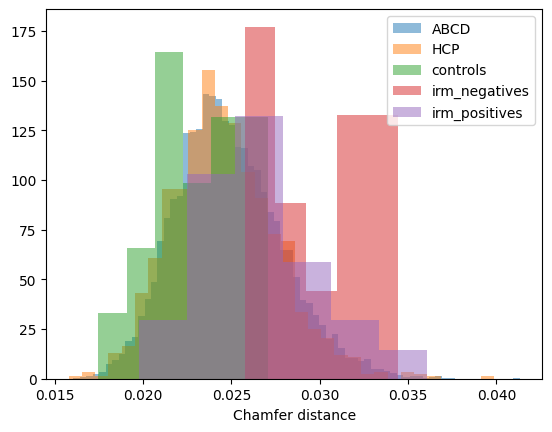

In [30]:
plt.hist(chamfer_ABCD, bins="auto", alpha=0.5, label="ABCD", density=True)
plt.hist(chamfer_hcp, bins="auto", alpha=0.5, label="HCP", density=True)
plt.hist(chamfer_control, bins="auto", alpha=0.5, label="controls", density=True)
plt.hist(chamfer_neg, bins="auto", alpha=0.5, label="irm_negatives", density=True)
plt.hist(chamfer_pos, bins="auto", alpha=0.5, label="irm_positives", density=True)

plt.xlabel("Chamfer distance")

#plt.title("Reconstruction error on subjects with epilepsy")
plt.legend()
plt.show()